# Milestone 03
# Kent Go

In this project, we will use SECOM production dataset and create several classification models to determine if we can predict defective products during the manufacturing process by using previously collected data. Some of the classification techniques that we will use include:
1. Simple Neural Networks
1. Deep Neural Networks
1. Recurrent Neural Networks
    
After creating the models, we will measure their performance and compare them.

## 0. Import Packages, Define Functions & Prepare Dataset

We will import necessary packages and define several functions to plot our model performance and results. We will also set a seed value for reproducability. The next step is to import and pre-process the dataset before being used to create and test our model. Some pre-processing techniques that we will use include:
- Split dataset into training and testing sets
- Apply SMOTE technique to handle class imbalance
- Remove non-predictive features and features that are missing 50%+ of their entries

In [1]:
#import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplot
from IPython.display import Image
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

%matplotlib inline

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module

In [2]:
#plot model performance

def plot_train_test_performance(model):

    fig = plt.figure(figsize = [8,8])
    plt.subplot(2,1,1)
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'lower right')

    plt.subplot(2,1,2)
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper right')
    plt.tight_layout()

In [3]:
#set seed for reproducible results

seed_value = 1
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
#define score_plot function

def score_plot(y_test, y_pred, y_predproba):
    
    #calculate accuracy, precision, recall & auc scores

    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred))
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('tn, fp, fn, tp: ', tn, fp, fn, tp, '\n')

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: ', acc_score.round(2), '\n')

    prec_score = precision_score(y_test, y_pred, pos_label=1)
    print('Precision Score: ', prec_score.round(2), '\n')

    rec_score = recall_score(y_test, y_pred, pos_label=1)
    print('Recall Score: ', rec_score.round(2), '\n')

    f1 = f1_score(y_test, y_pred) 
    print('F1 Score: ', f1.round(2), '\n')
    
    class_report = classification_report(y_test, y_pred)
    print('Classification Report: \n', class_report,'\n')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    rocauc_score = roc_auc_score(y_test, y_predproba[:,1])
    print('ROC AUC Score:', rocauc_score.round(2))

    skplot.metrics.plot_roc_curve(y_test, y_predproba)
    plt.show()

In [5]:
#read & merge data

url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'

url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'


fnames = ['feature' + str(x) for x in range(1, 591)]

df_a = pd.read_csv(url1, sep=' ', header=None, names=fnames, na_values=np.NaN) 

df_b = pd.read_csv(url2, sep=' ', names=['result','date'], parse_dates=['date'], na_values=np.NaN)

df = pd.concat([df_a, df_b], axis=1)

print('Dataset shape:', df.shape, '\n')

df.loc[df['result']==-1, 'result'] = 0

df.head()

Dataset shape: (1567, 592) 



,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result,date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [6]:
#remove features that are missing more than 50% of their values

missing = pd.DataFrame(df.isnull().sum()/len(df) > 0.5).rename(columns={0: '50%+'})
df1 = df.loc[:, ~missing['50%+']]

#remove non-predictive date feature
df1 = df1.drop('date', axis=1)

print('Shape of Dataset after Removing Features with 50% missing values: ', df1.shape)


#replace remaining missing values with the median value of the feature

df1.replace(np.NaN, df1[df1.columns].median(), inplace=True)


#scale dataset

df2 = df1.copy(deep = True)

for col in df1.drop('result', axis=1).columns:
    df2[col] = StandardScaler().fit_transform(df1[col].values.reshape(-1, 1))


df2.head()

Shape of Dataset after Removing Features with 50% missing values:  (1567, 563)


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,0.0,-0.564354,0.265894,0.509848,1.128455,...,-0.135520,0.118679,-0.204833,-0.093165,-0.197057,-0.077554,-0.190165,-0.238334,-0.295753,0
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.0,0.197639,0.321868,0.457021,0.022620,...,-0.460054,0.530183,0.406734,0.444748,0.385113,-0.960123,0.411970,0.250272,1.156846,0
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,0.0,-0.906768,0.254699,-0.260885,0.327222,...,-0.590505,-1.262799,0.022320,0.014418,0.029888,2.991195,3.627143,3.321511,-0.178955,1
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.0,0.502662,-0.013974,0.343240,-0.765369,...,-0.645708,-0.322218,-0.292200,-0.362121,-0.283360,-0.101845,-0.178804,-0.308135,-0.275049,0
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,0.0,-0.115954,0.187531,0.545066,-0.149545,...,-0.454486,-5.906917,26.867221,27.071429,26.913337,-0.101845,-0.178804,-0.308135,-0.275049,0


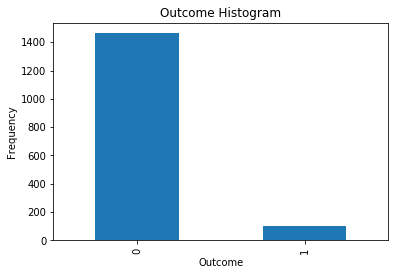

Outcomes: 
 0    1463
1     104
Name: result, dtype: int64


In [7]:
#plot histogram of the outcome

df2['result'].value_counts().plot(kind='bar')
plt.title('Outcome Histogram')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

print('Outcomes: \n', df2['result'].value_counts())

After performing EDA and analyzing the distribution, we notice that there are quite a few features that contain the same value in every row. Since these features are non-predictive, we will remove these features to further simplify our dataset. We will also perform SMOTE to handle class imbalance.

In [8]:
#remove features that contain the same value in all rows

cols_to_drop = []

for col in df2.drop('result', axis=1):
    if df2[col].nunique() == 1:
        cols_to_drop.append(col)

print('No. of features that have the same value in all rows: ', len(cols_to_drop), '\n')

df3 = df2.drop(cols_to_drop, axis=1)

print('Shape of Cleaned Dataset: ', df3.shape)

df3.head()

No. of features that have the same value in all rows:  116 

Shape of Cleaned Dataset:  (1567, 447)


,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,-0.564354,0.265894,0.509848,1.128455,-0.381577,...,-0.135520,0.118679,-0.204833,-0.093165,-0.197057,-0.077554,-0.190165,-0.238334,-0.295753,0
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.197639,0.321868,0.457021,0.022620,-1.608281,...,-0.460054,0.530183,0.406734,0.444748,0.385113,-0.960123,0.411970,0.250272,1.156846,0
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,-0.906768,0.254699,-0.260885,0.327222,0.124169,...,-0.590505,-1.262799,0.022320,0.014418,0.029888,2.991195,3.627143,3.321511,-0.178955,1
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.502662,-0.013974,0.343240,-0.765369,-0.370817,...,-0.645708,-0.322218,-0.292200,-0.362121,-0.283360,-0.101845,-0.178804,-0.308135,-0.275049,0
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,-0.115954,0.187531,0.545066,-0.149545,-0.790478,...,-0.454486,-5.906917,26.867221,27.071429,26.913337,-0.101845,-0.178804,-0.308135,-0.275049,0


We will split our clean dataset into training and testing sets to be used to build our models.

From the EDA plot, we notice that there's a significant class imbalance: 1463 for Outome = -1 and 104 for Outcome = 1. We need to handle this class imbalance to improve our future score metrics. We will achieve this by applying the SMOTE technique on the dataset.

In [9]:
#split dataset into training & testing sets

X = df3.drop('result', axis=1)
y = df3['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_value)

X_train.shape

(1253, 446)

In [10]:
#standardize features

for col in X_train.columns:
    X_train[col] = StandardScaler().fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = StandardScaler().fit_transform(X_test[col].values.reshape(-1, 1))


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [11]:
#apply smote to training data set to handle class imbalace

sm = SMOTE(random_state=seed_value)

X_res, y_res = sm.fit_sample(X_train, y_train)

X_res = pd.DataFrame(X_res, columns = X.columns)

print('Resampled Training set shape:', X_res.shape)

X_res.head()

Resampled Training set shape: (2338, 446)


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature577,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,-0.958467,0.927414,-0.213151,2.120612,-0.039812,-2.270712,0.145401,-0.562090,0.600873,0.765370,...,4.793848,6.258281,-0.699336,0.051676,-0.089226,0.051674,2.667295,0.128099,-0.080561,-0.716163
1,-1.059013,0.038153,-2.912901,0.331932,-0.056596,-0.367730,0.535309,-0.241626,-0.670973,0.611086,...,-0.226081,0.318446,0.399215,-0.384650,-0.355707,-0.371155,0.025799,-0.256366,-0.283392,-0.372561
2,-1.433269,0.753985,0.100685,2.789345,-0.053158,-2.382131,0.183134,-0.251012,-0.573139,-0.479924,...,-0.254379,0.291199,-0.439153,-0.006151,0.056127,-0.005704,-0.897133,0.204992,0.257492,0.801705
3,0.462867,-0.762006,0.419008,-0.652213,-0.066446,0.487630,-0.106152,1.316443,0.013867,-0.590127,...,-0.233396,-0.689358,-1.046247,-0.247970,-0.186128,-0.233297,-0.411798,1.665959,1.643509,0.956500
4,-0.299609,1.183284,0.760117,0.774160,-0.046100,-0.689973,0.271178,1.197107,-1.740629,0.677208,...,-0.211346,-0.467898,1.121947,-0.016664,-0.040775,-0.021618,-0.395885,-0.377197,-0.486224,-0.227992


#feature selection using lasso technique

lasso = Lasso(alpha=0.01, random_state = seed_value)
lasso.fit(X_res, y_res)


#features chosen

ll = pd.DataFrame({'col': X_res.columns, 'coef': lasso.coef_})

a = 1
lasso_features = []

for i in ll[ll['coef']!=0]['col']:
    ##print(a, '-', i)
    lasso_features.append(i)
    a += 1
    
print('No. of Features Chosen: ', a-1)

In [12]:
#subset x to only include selected features

#X_train2 = X_res[lasso_features]
#X_test2 = X_test[lasso_features]

X_train2 = X_res.copy(deep=True)
X_test2 = X_test.copy(deep=True)

X_train2.head()

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature577,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,-0.958467,0.927414,-0.213151,2.120612,-0.039812,-2.270712,0.145401,-0.562090,0.600873,0.765370,...,4.793848,6.258281,-0.699336,0.051676,-0.089226,0.051674,2.667295,0.128099,-0.080561,-0.716163
1,-1.059013,0.038153,-2.912901,0.331932,-0.056596,-0.367730,0.535309,-0.241626,-0.670973,0.611086,...,-0.226081,0.318446,0.399215,-0.384650,-0.355707,-0.371155,0.025799,-0.256366,-0.283392,-0.372561
2,-1.433269,0.753985,0.100685,2.789345,-0.053158,-2.382131,0.183134,-0.251012,-0.573139,-0.479924,...,-0.254379,0.291199,-0.439153,-0.006151,0.056127,-0.005704,-0.897133,0.204992,0.257492,0.801705
3,0.462867,-0.762006,0.419008,-0.652213,-0.066446,0.487630,-0.106152,1.316443,0.013867,-0.590127,...,-0.233396,-0.689358,-1.046247,-0.247970,-0.186128,-0.233297,-0.411798,1.665959,1.643509,0.956500
4,-0.299609,1.183284,0.760117,0.774160,-0.046100,-0.689973,0.271178,1.197107,-1.740629,0.677208,...,-0.211346,-0.467898,1.121947,-0.016664,-0.040775,-0.021618,-0.395885,-0.377197,-0.486224,-0.227992


In [13]:
#logistic regression with lasso regularization

logreg = LogisticRegression(random_state=seed_value, penalty='l1', solver='liblinear')

logreg.fit(X_train2, y_res)

y_pred_logreg = logreg.predict(X_test2)
y_predproba_logreg = logreg.predict_proba(X_test2)

acc_logreg_train = accuracy_score(y_res, logreg.predict(X_train2))

acc_logreg_test = accuracy_score(y_test, y_pred_logreg)

print('Logistic Regression Accuracy Score - Training Set: ', acc_logreg_train.round(3), '\n')

print('Logistic Regression Accuracy Score - Testing Set: ', acc_logreg_test.round(3), '\n')

Logistic Regression Accuracy Score - Training Set:  0.992 

Logistic Regression Accuracy Score - Testing Set:  0.85 



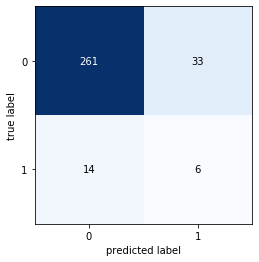

tn, fp, fn, tp:  261 33 14 6 

Accuracy Score:  0.85 

Precision Score:  0.15 

Recall Score:  0.3 

F1 Score:  0.2 

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       294
           1       0.15      0.30      0.20        20

    accuracy                           0.85       314
   macro avg       0.55      0.59      0.56       314
weighted avg       0.90      0.85      0.87       314
 

ROC AUC Score: 0.74


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


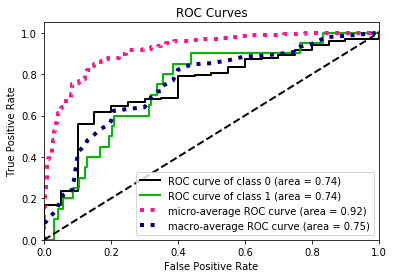

In [14]:
score_plot(y_test, y_pred_logreg, y_predproba_logreg)

## 1. Simple Neural Networks

The first model that we're going to apply is the Simple Neural Networks model.

In [15]:
#one hot encode y

n_classes = 2

y_train2 = keras.utils.to_categorical(y_res, n_classes)
y_test2 = keras.utils.to_categorical(y_test, n_classes)

In [16]:
#simple neural network model

keras.layers.Conv2D

snn = keras.Sequential([
    keras.layers.Flatten(input_shape = X_train2.shape[1:]),
    #keras.layers.Dense(128, activation = tf.nn.relu), #1 dense hidden layer
    keras.layers.Dense(n_classes, activation = tf.nn.softmax) #output layer
])


snn.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy', #sparse_
              metrics = ['accuracy'])

In [17]:
#fit model using training dataset

n_epochs = 10

snn.fit(X_train2, y_train2, epochs = n_epochs, batch_size = 64, verbose = 1, validation_data = (X_test2, y_test2))

Epoch 1/10
37/37 [==============================] - 0s 6ms/step - loss: 0.7256 - accuracy: 0.6660 - val_loss: 0.9833 - val_accuracy: 0.5159
Epoch 2/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.7528 - val_loss: 0.9131 - val_accuracy: 0.5255
Epoch 3/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5052 - accuracy: 0.7883 - val_loss: 0.8409 - val_accuracy: 0.5605
Epoch 4/10
37/37 [==============================] - 0s 2ms/step - loss: 0.4666 - accuracy: 0.8092 - val_loss: 0.7912 - val_accuracy: 0.5828
Epoch 5/10
37/37 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.8161 - val_loss: 0.7497 - val_accuracy: 0.6019
Epoch 6/10
37/37 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.8306 - val_loss: 0.7140 - val_accuracy: 0.6274
Epoch 7/10
37/37 [==============================] - 0s 2ms/step - loss: 0.3960 - accuracy: 0.8383 - val_loss: 0.6798 - val_accuracy: 0.6529
Epoch 8/10
37/37 [==

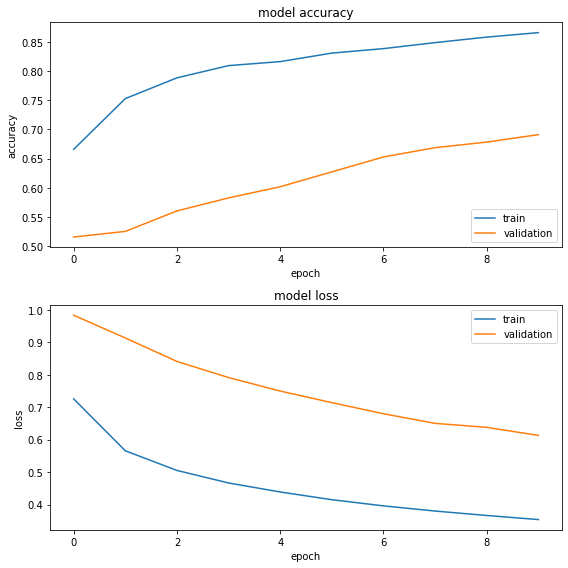

In [18]:
plot_train_test_performance(snn)

In [19]:
#calculate training accuracy

train_loss_snn, train_acc_snn = snn.evaluate(X_train2, y_train2)

print('Train accuracy:', train_acc_snn)

74/74 [==============================] - 0s 800us/step - loss: 0.3399 - accuracy: 0.8743
Train accuracy: 0.8742514848709106


In [20]:
#predict using testing dataset & testing accuracy

y_pred_snn = snn.predict(X_test2)

test_loss_snn, test_acc_snn = snn.evaluate(X_test2, y_test2)

print('Test accuracy:', test_acc_snn)

10/10 [==============================] - 0s 872us/step - loss: 0.6132 - accuracy: 0.6911
Test accuracy: 0.691082775592804


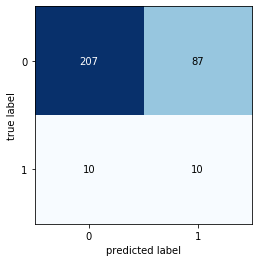

tn, fp, fn, tp:  207 87 10 10 

Accuracy Score:  0.69 

Precision Score:  0.1 

Recall Score:  0.5 

F1 Score:  0.17 

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.70      0.81       294
           1       0.10      0.50      0.17        20

    accuracy                           0.69       314
   macro avg       0.53      0.60      0.49       314
weighted avg       0.90      0.69      0.77       314
 

ROC AUC Score: 0.65


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


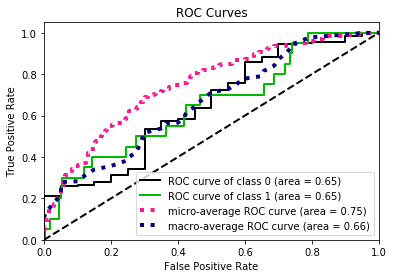

In [21]:
y_pred_snn_bool = np.argmax(y_pred_snn, axis=1)

score_plot(y_test, y_pred_snn_bool, y_pred_snn)

## 2. Deep Neural Networks

The next model that we're going to apply is the Deep Neural Networks model.

In [22]:
#deep neural network model

dnn = keras.Sequential([
    keras.layers.Flatten(input_shape = X_train2.shape[1:]),
    keras.layers.Dense(128, activation = tf.nn.relu),
    keras.layers.Dense(128, activation = tf.nn.relu),
    keras.layers.Dense(n_classes, activation = tf.nn.softmax) #output layer
])


dnn.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy', #sparse_
              metrics = ['accuracy'])

In [23]:
#fit model using training dataset

dnn.fit(X_train2, y_train2, epochs = n_epochs, batch_size = 64, verbose = 1, validation_data = (X_test2, y_test2))

Epoch 1/10
37/37 [==============================] - 0s 7ms/step - loss: 0.3560 - accuracy: 0.8648 - val_loss: 0.3356 - val_accuracy: 0.8822
Epoch 2/10
37/37 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.9880 - val_loss: 0.3354 - val_accuracy: 0.9204
Epoch 3/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.3908 - val_accuracy: 0.9268
Epoch 4/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.4292 - val_accuracy: 0.9236
Epoch 5/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4558 - val_accuracy: 0.9172
Epoch 6/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4789 - val_accuracy: 0.9172
Epoch 7/10
37/37 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4988 - val_accuracy: 0.9172
Epoch 8/10
37/37 [==

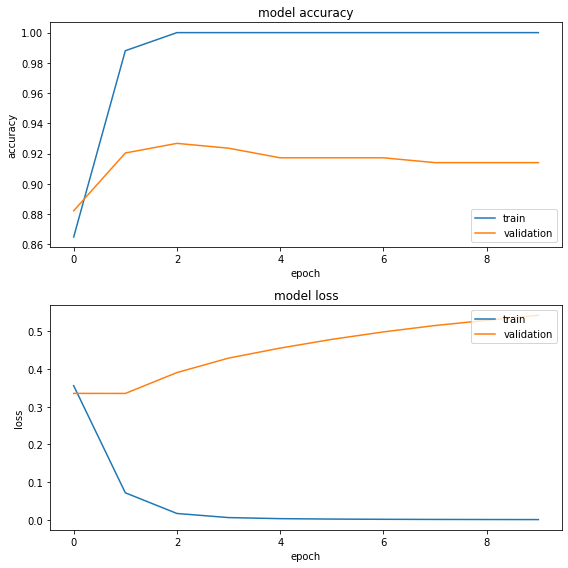

In [24]:
plot_train_test_performance(dnn)

In [25]:
#calculate training accuracy

train_loss_dnn, train_acc_dnn = dnn.evaluate(X_train2, y_train2)

print('Train accuracy:', train_acc_dnn)

74/74 [==============================] - 0s 768us/step - loss: 5.0907e-04 - accuracy: 1.0000
Train accuracy: 1.0


In [26]:
#predict using testing dataset & testing accuracy

y_pred_dnn = dnn.predict(X_test2)

test_loss_dnn, test_acc_dnn = dnn.evaluate(X_test2, y_test2)

print('Test accuracy:', test_acc_dnn)

10/10 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.9140
Test accuracy: 0.9140127301216125


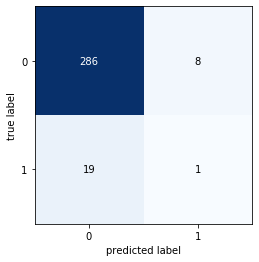

tn, fp, fn, tp:  286 8 19 1 

Accuracy Score:  0.91 

Precision Score:  0.11 

Recall Score:  0.05 

F1 Score:  0.07 

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       294
           1       0.11      0.05      0.07        20

    accuracy                           0.91       314
   macro avg       0.52      0.51      0.51       314
weighted avg       0.89      0.91      0.90       314
 

ROC AUC Score: 0.64


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


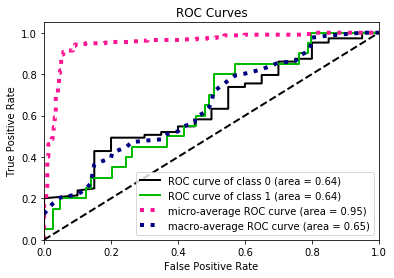

In [27]:
y_pred_dnn_bool = np.argmax(y_pred_dnn, axis=1)

score_plot(y_test, y_pred_dnn_bool, y_pred_dnn)

## 3. Recurrent Neural Networks

The next model that we're going to apply is the Recurrent Neural Networks model.

In [28]:
X_train22 = X_train2.to_numpy() 
X_train22 = X_train22.reshape((X_train2.shape[0], X_train2.shape[1], 1))

X_test22 = X_test2.to_numpy() 
X_test22 = X_test22.reshape((X_test2.shape[0], X_test2.shape[1], 1))

X_train22.shape

(2338, 446, 1)

In [29]:
#recurrent neural network model

rnn = keras.models.Sequential()

rnn.add(keras.layers.LSTM(128, input_shape = X_train22.shape[1:]))
rnn.add(keras.layers.Dense(128, activation = 'relu'))
rnn.add(keras.layers.Dense(n_classes, activation = 'relu'))

rnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(rnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 83,330
Trainable params: 83,330
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
#fit model

rnn.fit(X_train22, y_train2, epochs = n_epochs, batch_size = 64, verbose = 1, validation_data = (X_test22, y_test2))

Epoch 1/10
37/37 [==============================] - 13s 363ms/step - loss: 1.4025 - accuracy: 0.5124 - val_loss: 0.6734 - val_accuracy: 0.7070
Epoch 2/10
37/37 [==============================] - 13s 352ms/step - loss: 0.6895 - accuracy: 0.5586 - val_loss: 0.6746 - val_accuracy: 0.5828
Epoch 3/10
37/37 [==============================] - 13s 354ms/step - loss: 0.6772 - accuracy: 0.6116 - val_loss: 0.6122 - val_accuracy: 0.6783
Epoch 4/10
37/37 [==============================] - 13s 354ms/step - loss: 0.6624 - accuracy: 0.6206 - val_loss: 0.6481 - val_accuracy: 0.5764
Epoch 5/10
37/37 [==============================] - 13s 352ms/step - loss: 0.6521 - accuracy: 0.6155 - val_loss: 0.6612 - val_accuracy: 0.5796
Epoch 6/10
37/37 [==============================] - 13s 353ms/step - loss: 0.6833 - accuracy: 0.6086 - val_loss: 0.7749 - val_accuracy: 0.6815
Epoch 7/10
37/37 [==============================] - 13s 347ms/step - loss: 0.6700 - accuracy: 0.6014 - val_loss: 0.6533 - val_accuracy: 0.6497

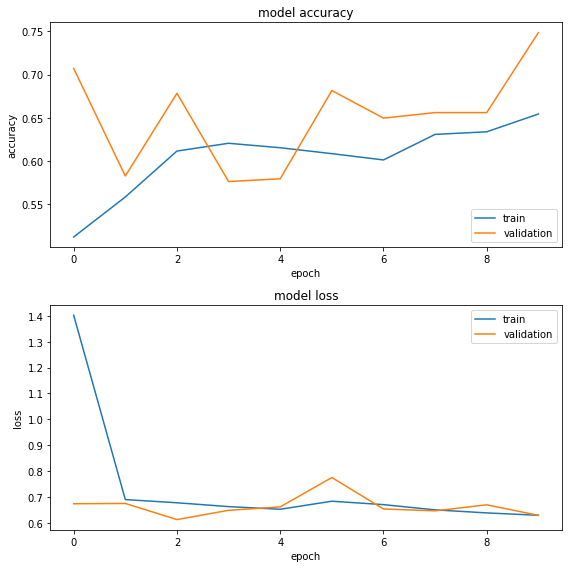

In [31]:
plot_train_test_performance(rnn)

In [32]:
#calculate training accuracy

train_loss_rnn, train_acc_rnn = rnn.evaluate(X_train22, y_train2)

print('Train accuracy:', train_acc_rnn)

74/74 [==============================] - 4s 61ms/step - loss: 0.6348 - accuracy: 0.6471
Train accuracy: 0.6471343040466309


In [33]:
#predict using testing dataset & testing accuracy

y_pred_rnn = rnn.predict(X_test22)

test_loss_rnn, test_acc_rnn = rnn.evaluate(X_test22, y_test2)

print('Test accuracy:', test_acc_rnn)

10/10 [==============================] - 1s 55ms/step - loss: 0.6286 - accuracy: 0.7484
Test accuracy: 0.7484076619148254


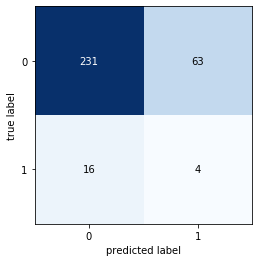

tn, fp, fn, tp:  231 63 16 4 

Accuracy Score:  0.75 

Precision Score:  0.06 

Recall Score:  0.2 

F1 Score:  0.09 

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.79      0.85       294
           1       0.06      0.20      0.09        20

    accuracy                           0.75       314
   macro avg       0.50      0.49      0.47       314
weighted avg       0.88      0.75      0.81       314
 

ROC AUC Score: 0.49


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


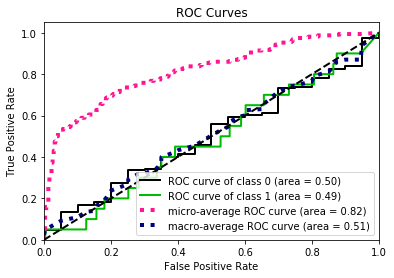

In [34]:
y_pred_rnn_bool = np.argmax(y_pred_rnn, axis=1)

score_plot(y_test, y_pred_rnn_bool, y_pred_rnn)

## 4. Findings & Discussion

Our main goal for this project is to apply Neural Network classification models (Simple NN, Deep NN and Recurrent NN) to predict and identify defective products during the production process. To achieve this, we will use data collected from sensors installed throughout the manufacturing process to fit and test our Neural Network models.

The first step is to prepare the dataset to be used in our model. We perform dataset train/test split, class balancing and removing non-predictive features prior to creating our models to simplify our dataset and prevent overfitting. We then create several different models (SNN, DNN and RNN) and measure their peroformance (training and testing accuracy scores, losses as well as AUC). Below is the summary of our model performance:

| Model | Training Accuracy | Testing Accuracy | Training Loss | Testing Loss | AUC |
| --- | --- | --- | --- | --- | --- |
| Log Reg | 0.99 | 0.85 | --- | --- | 0.74 |
| Simple NN | 0.87 | 0.69 | 0.35 | 0.61 | 0.65 |
| Deep NN | 1.00 | 0.91 | 0.01 | 0.54 | 0.64 |
| Recurrent NN | 0.65 | 0.75 | 0.63 | 0.63 | 0.50 |

Based on the model performance summary above, the Deep Neural Network (DNN) model outperforms the other models due to its high Accuracy scores, low Loss values and satisfactory AUC. The second best model is the basic Logistic Regression, followed by Simple Neural Network and Recurrent Neural Network.

The model will allow our client to identify defective products during the manufacturing process. However, the poor Recall score (high false negative) indicates that some defective products are not caught and we need to improve our model. A few ways to improve our model include:
- Tune model hyperparameters:
    - Activation function
    - Optimizer
    - Loss function
    - No of layers
- Perform bootstrapping to increase size of the dataset